In [ ]:
!pip install pydot
!pip install pydotplus

Estados: {0, 1, 2, 3}
Alfabeto: {'b', 'a'}
Transiciones: {(0, 'a'): 1, (1, ''): 2, (2, 'b'): 3}
Estado Inicial: 0
Estados de Aceptación: {3}


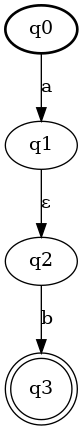

In [15]:
import pydot
from PIL import Image
from IPython.display import display

class AFND:
    def __init__(self, estados, alfabeto, transiciones, estado_inicial, estados_aceptacion):
        self.estados = estados
        self.alfabeto = alfabeto
        self.transiciones = transiciones
        self.estado_inicial = estado_inicial
        self.estados_aceptacion = estados_aceptacion

def construir_afnd(expresion_regular):
    estados = set()
    alfabeto = set()
    transiciones = {}
    estado_inicial = 0
    estados_aceptacion = set()
    estado_actual = estado_inicial
    estados.add(estado_actual)

    for caracter in expresion_regular:
        if caracter in ('a', 'b', 'c'):
            alfabeto.add(caracter)
            estado_siguiente = estado_actual + 1
            estados.add(estado_siguiente)
            transiciones[(estado_actual, caracter)] = estado_siguiente
            estado_actual = estado_siguiente
        elif caracter == '.':
            # Concatenación: Agregar una transición ε
            estado_siguiente = estado_actual + 1
            estados.add(estado_siguiente)
            transiciones[(estado_actual, '')] = estado_siguiente
            estado_actual = estado_siguiente
        elif caracter == '*':
            # Operador estrella: Agregar una transición ε desde el último estado de repetición hasta el primer estado de repetición
            transiciones[(estado_actual, '')] = estado_inicial
        elif caracter == 'U':
            # Operador unión: Crear un nuevo estado inicial y conectar con ε a los estados iniciales de ambas expresiones
            nuevo_estado_inicial = estado_inicial - 1

    # Agregar el estado final al último estado de la expresión regular
    estados_aceptacion.add(estado_actual)

    return AFND(estados, alfabeto, transiciones, estado_inicial, estados_aceptacion)

def dibujar_afnd(afnd):
    graph = pydot.Dot(graph_type='digraph')
    for estado in afnd.estados:
        if estado == afnd.estado_inicial:
            node = pydot.Node(str(estado), shape='ellipse', style='bold', label=f'q{estado}')
        elif estado in afnd.estados_aceptacion:
            node = pydot.Node(str(estado), shape='doublecircle', label=f'q{estado}')
        else:
            node = pydot.Node(str(estado), shape='ellipse', label=f'q{estado}')
        graph.add_node(node)

    for transicion, destino in afnd.transiciones.items():
        if transicion[1] == '':
            edge = pydot.Edge(str(transicion[0]), str(destino), label='ε')
        else:
            edge = pydot.Edge(str(transicion[0]), str(destino), label=transicion[1])
        graph.add_edge(edge)

    graph.write_png('./afnd.png')
    im = Image.open('./afnd.png')
    display(im)

# Solicita la expresión regular al usuario
expresion_regular = input("Introduce la expresión regular: ")

# Construye el AFND
afnd = construir_afnd(expresion_regular)

# Muestra la representación textual del AFND
print("Estados:", afnd.estados)
print("Alfabeto:", afnd.alfabeto)
print("Transiciones:", afnd.transiciones)
print("Estado Inicial:", afnd.estado_inicial)
print("Estados de Aceptación:", afnd.estados_aceptacion)

# Dibuja el AFND y muestra la imagen
dibujar_afnd(afnd)